In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Extract downloaded files
# The download cells will store the data in nested directories starting here:
HCP_DIR = "/content/hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('/content')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy import stats
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# The download cells will store the data in nested directories starting here:


HCP_DIR = "./hcp_task"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
################################################################################
# NMA helper functions
################################################################################

def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, experiment, run, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment
    run (int) : 0-based run index, across all tasks

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"

    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list


# I split apart the syntax they give (commented out below) so it's easier to
# understand what the function does and how it does it
def average_frames(data, evs, experiment, cond):
  # 1. Pick out the frame‐indices for this condition
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  trial_frame_lists = evs[idx]  # a list, one entry per trial

  # 2. For each trial, average the data over its frames
  trial_averages = []
  for frames in trial_frame_lists:
      # data[:, frames] has shape (n_parcels, n_frames_in_this_trial)
      mean_over_frames = np.mean(
          data[:, frames],    # select those columns
          axis=1,             # average across time within that trial
          keepdims=True       # keep shape (n_parcels, 1) so concatenation works
      )
      trial_averages.append(mean_over_frames)

  # 3. Stack those trial‐means into one big array of shape (n_parcels, n_trials)
  concatenated = np.concatenate(trial_averages, axis=1)

  # 4. Finally, average across trials to get one number per parcel
  #    Result has shape (n_parcels, n_trials)
  condition_mean_timeseries = np.mean(concatenated, axis=1)

  return condition_mean_timeseries



#return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

In [ ]:
####################################################################
# Single-subject versions of the all-subject functions for testing
####################################################################


# These have some dependencies that are not always explicitly mentioned
# in the function arguments such as data, evs, run, experiment and region_info.
# I loaded them in cell[8] but you'll have to fiddle with them still,
# I built these for testing only and they throw weird errors sometimes

def get_network_data(network, evs, experiment, condition, data):
    """
    Returns a numpy array of the BOLD timeseries within the given network
    and a numpy array of the names for the parcels in each network

    Args:
        network: The functional network the parcel is apart of according to regions.npy
        evs: event structure
        experiment: experiment name
        condition: condition name
    """
    network = str(network)
    network_mask = region_info['network'] == network

    idx = EXPERIMENTS[experiment]['cond'].index(condition)
    trial_frame_lists = evs[idx]

    all_condition_frames = []
    for frames in trial_frame_lists:
        all_condition_frames.extend(frames)

    network_data = data[network_mask, :][:, all_condition_frames]
    network_parcels = np.array(region_info['name'])[network_mask].tolist()
    return network_data, network_parcels

def plot_network_activity_condition(data, evs, experiment, condition, region_info):
    """
    Plot network activity during specific task condition

    Args:
        data: timeseries data (n_parcels x n_timepoints)
        evs: event structure
        experiment: experiment name
        condition: condition name
        region_info: dictionary with network information
    """
    # Get frames for this condition (WM in our case)
    idx = EXPERIMENTS[experiment]['cond'].index(condition)
    trial_frame_lists = evs[idx]

    # Get unique networks
    networks = np.unique(region_info['network'])

    plt.figure(figsize=(15, 10))

    # Plot each trial
    for trial_idx, frames in enumerate(trial_frame_lists):
        plt.subplot(2, 1, 1)
        time_axis = np.arange(len(frames)) * TR

        for network in networks:
            network_mask = region_info['network'] == network
            network_activity = np.mean(data[network_mask, :][:, frames], axis=0)

            if trial_idx == 0:  # Only add label for first trial
                plt.plot(time_axis, network_activity, label=network, alpha=0.7)
            else:
                plt.plot(time_axis, network_activity, alpha=0.7)

    plt.xlabel('Time within trial (seconds)')
    plt.ylabel('BOLD Signal')
    plt.title(f'Network Activity During {condition} Trials')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot average across trials
    plt.subplot(2, 1, 2)

    # Collect all frames across trials
    all_frames = []
    for frames in trial_frame_lists:
        all_frames.extend(frames)

    # Average time course for each network
    for network in networks:
        network_mask = region_info['network'] == network

        # Get average activity for this condition
        condition_activity = average_frames(data, evs, experiment, condition)
        network_avg = np.mean(condition_activity[network_mask])

        plt.bar(network, network_avg, alpha=0.7, label=network)

    plt.xlabel('Network')
    plt.ylabel('Average BOLD Signal')
    plt.title(f'Average Network Activity - {condition}')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def get_net_corr(network_1, network_2, evs, experiment, condition):
    """
    Compute the cross‐network correlation matrix for two brain networks
    under a specific task condition.

    Args:
        network_1 (str): First network name.
        network_2 (str): Second network name.
        evs (list): Event‐structure listing frames for each condition.
        experiment (str): Experiment key (e.g. 'WM').
        condition (str): Condition key within the experiment
                         (e.g. '0bk_body').

    Returns:
        tuple:
            cross_network_corr (np.ndarray): Array of shape
                (n_parcels₂ × n_parcels₁) with correlations
                between network₂ (rows) and network₁ (cols).
            avg_corr (float): Mean of all entries in
                the cross‐network correlation matrix.
    """
    network_1_data, network_1_parcels = get_network_data(
        network_1, evs, experiment, condition
    )
    network_2_data, network_2_parcels = get_network_data(
        network_2, evs, experiment, condition
    )
    n1 = network_1_data.shape[0]

    combined_data = np.vstack([network_1_data, network_2_data])
    network_corr = np.corrcoef(combined_data)
    cross_network_corr = network_corr[n1:, :n1]

    avg_corr = np.mean(cross_network_corr)
    print(f"Corr({network_1},{network_2}) = {avg_corr:.3f}")

    return cross_network_corr, avg_corr




In [ ]:
############################################################################
# Helper functions
############################################################################


def compare_network_connectivity(matrix1, matrix2, condition1, condition2):
    """
    Evaluate and compare two cross‐network correlation matrices.

   Args:
        matrix1 : np.ndarray
            Correlation matrix for the first condition (shape: [n₂, n₁]).
        matrix2 : np.ndarray
            Correlation matrix for the second condition (shape: [n₂, n₁]).
        condition1 : str
            Label for the first condition (e.g. '0bk_body').
        condition2 : str
            Label for the second condition (e.g. '2bk_body').
    """
    print(f"=== {condition1} vs {condition2} Comparison ===")

    # Basic stats
    print(f"\n{condition1} stats:")
    print(f"  Mean: {np.mean(matrix1):.3f}")
    print(f"  Std:  {np.std(matrix1):.3f}")
    print(f"  Max:  {np.max(matrix1):.3f}")
    print(f"  Min:  {np.min(matrix1):.3f}")

    print(f"\n{condition2} stats:")
    print(f"  Mean: {np.mean(matrix2):.3f}")
    print(f"  Std:  {np.std(matrix2):.3f}")
    print(f"  Max:  {np.max(matrix2):.3f}")
    print(f"  Min:  {np.min(matrix2):.3f}")

    # Difference
    diff = matrix2 - matrix1
    print(f"\nDifference ({condition2} - {condition1}):")
    print(f"  Mean change: {np.mean(diff):.3f}")
    print(f"  Strongest increase: {np.max(diff):.3f}")
    print(f"  Strongest decrease: {np.min(diff):.3f}")

    # Statistical test
    t_stat, p_val = stats.ttest_rel(matrix1.flatten(), matrix2.flatten())
    print(f"\nStatistical test:")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_val:.6f}")
    print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")

def split_matrices(matrix):
    """
    Split a 2M×2M matrix into four M×M quadrants:
      R-R (upper-left), L-L (lower-right), R-L (upper-right), L-R (lower-left).

    Args:
        matrix (np.ndarray): A correlation matrix as returned by
          get_net_corr_all_subjects()

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            (r_r, l_l, r_l, l_r) blocks, each of shape (M, M).
    """
    n = matrix.shape[0] // 2
    r_r = matrix[:n, :n]
    l_l = matrix[n:, n:]
    r_l = matrix[:n, n:]
    l_r = matrix[n:, :n]
    return r_r, l_l, r_l, l_r

def pairwise_euclid(vecs):
    """
    Compute the pairwise Euclidean distance matrix for vecs.

    Args:
        vecs (Sequence[array_like]): A sequence of N numeric vectors.

    Returns:
        np.ndarray:
            An (N × N) array `D` where D[i, j] is the Euclidean distance
            between `vecs[i]` and `vecs[j]`. The matrix is symmetric and has
            zeros on its diagonal.
    """
    N = len(vecs)
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            D[i, j] = np.linalg.norm(vecs[i] - vecs[j])
    return D

def split_network_corr_by_quadrant(condition, exp, run):
    """
    Compute and split each network’s correlation matrix into four quadrants
    for the specified task condition.

    Args:
        condition (str): Condition key (e.g. '0bk_body', '2bk_faces').

    Returns:
        dict[str, dict[str, np.ndarray]]:
            Mapping from network name to a dict with keys:
              • 'R-R': right⇄right submatrix
              • 'L-L': left⇄left submatrix
              • 'R-L': right⇄left submatrix
              • 'L-R': left⇄right submatrix
    """
    network_dict = {}
    for net in unq_networks:
        corr_mtx, _ = get_net_corr_all_subjects(
            network_1=net, network_2=net,
            experiment=exp, condition=condition,
            run=run, subjects=test_subjects
        )
        r_r, l_l, r_l, l_r = split_matrices(corr_mtx)
        network_dict[net] = {
            'R-R': r_r,
            'L-L': l_l,
            'R-L': r_l,
            'L-R': l_r,
        }
    return network_dict


# Should be called quadrant averages but initially it was just for R-R and L-L
# and didn't bother to change the names. I updated the docstrings to reflect
# what its functionality is
def compute_hemisphere_averages(matrix_dict):
    """
    Compute average connectivity for each correlation matrix quadrant

    Args:
        matrix_dict: Dict with keys like 'R-R', 'L-L', 'R-L', 'L-R' and matrix values

    Returns:
        Dict with average connectivity values
    """
    return {block: np.mean(matrix) for block, matrix in matrix_dict.items()}

def analyze_hemisphere_connectivity(matrix_0bk, matrix_2bk, condition_names=('0bk', '2bk')):
    """
    Complete hemisphere connectivity analysis for two conditions

    Args:
        matrix_0bk, matrix_2bk: Correlation matrices for two conditions
        condition_names: Tuple with names for the conditions

    Returns:
        Dictionary with results for both conditions
    """
    # Split matrices into hemisphere blocks
    r_r_0bk, l_l_0bk, r_l_0bk, l_r_0bk = split_matrices(matrix_0bk)
    r_r_2bk, l_l_2bk, r_l_2bk, l_r_2bk = split_matrices(matrix_2bk)

    # Organize into dictionaries
    blocks_0bk = {'R-R': r_r_0bk, 'L-L': l_l_0bk, 'R-L': r_l_0bk, 'L-R': l_r_0bk}
    blocks_2bk = {'R-R': r_r_2bk, 'L-L': l_l_2bk, 'R-L': r_l_2bk, 'L-R': l_r_2bk}

    # Compute averages
    avg_0bk = compute_hemisphere_averages(blocks_0bk)
    avg_2bk = compute_hemisphere_averages(blocks_2bk)

    # Print results
    cond1, cond2 = condition_names
    print(f"\n{cond1} Connectivity Averages:")
    print(f"R-R: {avg_0bk['R-R']:.3f}, L-L: {avg_0bk['L-L']:.3f}, R-L: {avg_0bk['R-L']:.3f}, L-R: {avg_0bk['L-R']:.3f}")
    print(f"\n{cond2} Connectivity Averages:")
    print(f"R-R: {avg_2bk['R-R']:.3f}, L-L: {avg_2bk['L-L']:.3f}, R-L: {avg_2bk['R-L']:.3f}, L-R: {avg_2bk['L-R']:.3f}")

    return {
        cond1: avg_0bk,
        cond2: avg_2bk,
        'blocks': {cond1: blocks_0bk, cond2: blocks_2bk}
    }


##############################################################################
# All-subject functions for extracting data & calculating correlation matrices
##############################################################################

def get_network_data_all_subjects(network, experiment, condition, run=1, subjects=None):
    """
    Returns BOLD timeseries for a network across all subjects

    Args:
        network: The functional network name
        experiment: experiment name (e.g., 'WM')
        condition: condition name (e.g., '0bk_body')
        run: which run to use (0 or 1)
        subjects: list of subject IDs (if None, loads from subjects_list.txt)

    Returns:
        all_network_data: concatenated data from all subjects
        network_parcels: parcel names in the network
    """
    if subjects is None:
        # Load subjects from the text file
        subjects_file = f"{HCP_DIR}/subjects_list.txt"
        subjects = np.loadtxt(subjects_file, dtype=str)
        print(f"Loaded {len(subjects)} subjects from {subjects_file}")

    network = str(network)

    # Get network mask (same for all subjects)
    network_mask = region_info['network'] == network
    network_parcels = np.array(region_info['name'])[network_mask].tolist()

    all_network_data = []
    successful_subjects = []

    for subject in subjects:
        try:
            # Load data for this subject (note: no dir parameter needed now)
            subject_data = load_single_timeseries(subject, experiment, run, dir=None, remove_mean=True)

            # Load events for this subject
            subject_evs = load_evs(subject, experiment, run, dir=None)

            # Get condition frames
            idx = EXPERIMENTS[experiment]['cond'].index(condition)
            trial_frame_lists = subject_evs[idx]

            # Get all frames for this condition
            all_condition_frames = []
            for frames in trial_frame_lists:
                all_condition_frames.extend(frames)

            # Extract network data for this condition
            subject_network_data = subject_data[network_mask, :][:, all_condition_frames]
            all_network_data.append(subject_network_data)
            successful_subjects.append(subject)

        except Exception as e:
            print(f"Skipping subject {subject}: {e}")
            continue

    # Concatenate all subjects' data along time dimension
    if all_network_data:
        concatenated_data = np.concatenate(all_network_data, axis=1)
        print(f"Loaded {len(successful_subjects)} subjects for {network} network")
        print(f"Final data shape: {concatenated_data.shape}")
        return concatenated_data, network_parcels
    else:
        raise ValueError("No valid subject data found")

# I use this to calculate within network correlations by giving it the same network
# for both network_1 and network_2
def get_net_corr_all_subjects(network_1, network_2, experiment, condition, run=1, subjects=None):
    """
    Compute cross-network correlation across all subjects

    Args:
        network_1, network_2: Network names to correlate
        experiment: experiment name
        condition: condition name
        run: which run to use
        subjects: list of subject IDs (if None, uses all available)

    Returns:
        cross_network_corr: correlation matrix between networks
        avg_corr: average correlation strength
    """
    print(f"Computing {network_1} vs {network_2} correlation for condition '{condition}'")
    print(f"Across {len(subjects) if subjects else N_SUBJECTS} subjects...")

    # Get network data for all subjects
    network_1_data, network_1_parcels = get_network_data_all_subjects(
        network_1, experiment, condition, run, subjects)

    network_2_data, network_2_parcels = get_network_data_all_subjects(
        network_2, experiment, condition, run, subjects)

    # Compute correlation
    n1 = network_1_data.shape[0]
    combined_data = np.vstack([network_1_data, network_2_data])

    network_corr = np.corrcoef(combined_data)
    cross_network_corr = network_corr[n1:, :n1]

    avg_corr = np.mean(cross_network_corr)
    print(f"Corr({network_1},{network_2}) = {avg_corr:.3f}")

    return cross_network_corr, avg_corr


# **USED IN CLASSIFIER TO BUILD FEATURE VECTORS**
def get_all_networks_features_subject_level(experiment='WM', run=1, subjects=None):
    """
    Get correlation features from all networks for all WM conditions for each subject.

    This creates many samples by computing correlation matrices for each subject
    individually, then extracting features from all networks.

    Args:
        experiment: experiment name (default 'WM')
        run: which run to use
        subjects: list of subject IDs (if None, uses all available)

    Returns:
        X: Feature matrix (n_samples x n_features)
        y: Labels (0=0bk, 1=2bk)
        sample_info: List of tuples (subject, condition) for each sample
    """
    print("=== Getting Subject-Level Features from All Networks ===")

    # Load subjects if not provided
    if subjects is None:
        subjects_file = f"{HCP_DIR}/subjects_list.txt"
        subjects = np.loadtxt(subjects_file, dtype=str).tolist()
        print(f"Loaded {len(subjects)} subjects from {subjects_file}")

    # Get all WM conditions
    wm_conditions = EXPERIMENTS[experiment]['cond']
    zerobk_conditions = [cond for cond in wm_conditions if '0bk' in cond]
    twobk_conditions = [cond for cond in wm_conditions if '2bk' in cond]

    print(f"0bk conditions: {zerobk_conditions}")
    print(f"2bk conditions: {twobk_conditions}")
    print(f"Networks: {list(unq_networks)}")

    X = []
    y = []
    sample_info = []

    # Process all conditions and subjects
    all_conditions = [(cond, 0) for cond in zerobk_conditions] + [(cond, 1) for cond in twobk_conditions]

    for condition, label in all_conditions:
        print(f"\nProcessing {condition}...")

        for subject in subjects:
            try:
                # Get correlation features from all networks for this subject and condition
                subject_features = []

                for network in unq_networks:
                    try:
                        # Load data for this specific subject
                        subject_data = load_single_timeseries(subject, experiment, run, dir=None, remove_mean=True)
                        subject_evs = load_evs(subject, experiment, run, dir=None)

                        # Get network data for this condition
                        network_mask = region_info['network'] == network

                        # Get condition frames
                        idx = EXPERIMENTS[experiment]['cond'].index(condition)
                        trial_frame_lists = subject_evs[idx]

                        # Get all frames for this condition
                        all_condition_frames = []
                        for frames in trial_frame_lists:
                            all_condition_frames.extend(frames)

                        # Extract network data
                        network_data = subject_data[network_mask, :][:, all_condition_frames]

                        # Compute within-network correlation matrix
                        network_corr = np.corrcoef(network_data)

                        # Extract upper triangular correlations (excluding diagonal)
                        triu_indices = np.triu_indices(network_corr.shape[0], k=1)
                        network_features = network_corr[triu_indices]

                        subject_features.extend(network_features)

                    except Exception as e:
                        print(f"Warning: Failed to get {network} features for {subject} {condition}: {e}")
                        continue

                if subject_features:
                    X.append(np.array(subject_features))
                    y.append(label)
                    sample_info.append((subject, condition))

            except Exception as e:
                print(f"Skipping subject {subject} for {condition}: {e}")
                continue

        print(f"  Added {sum(1 for _, cond in sample_info if cond == condition)} samples for {condition}")

    X = np.array(X)
    y = np.array(y)

    print(f"\nFeature extraction complete:")
    print(f"  Total samples: {len(X)}")
    print(f"  Features per sample: {X.shape[1]} (from all networks combined)")
    print(f"  Class distribution: {np.bincount(y)} (0=0bk, 1=2bk)")
    print(f"  Subjects x Conditions: {len(subjects)} x {len(all_conditions)} = {len(subjects) * len(all_conditions)} potential samples")

    return X, y, sample_info

def get_single_network_features_subject_level(network, experiment='WM', run=1, subjects=None):
    """
    Get correlation features from a SINGLE network for all WM conditions for each subject.

    Args:
        network (str): Name of the network to extract features from
        experiment (str): Experiment name (default 'WM')
        run (int): Which run to use
        subjects (list): List of subject IDs (if None, uses all available)

    Returns:
        tuple:
            X (np.ndarray): Feature matrix (n_samples x n_features)
            y (np.ndarray): Labels (0=0bk, 1=2bk)
            sample_info (list): List of tuples (subject, condition) for each sample
    """
    print(f"=== Getting Subject-Level Features from {network} Network ===")

    # Load subjects if not provided
    if subjects is None:
        subjects_file = f"{HCP_DIR}/subjects_list.txt"
        subjects = np.loadtxt(subjects_file, dtype=str).tolist()
        print(f"Loaded {len(subjects)} subjects from {subjects_file}")

    # Get all WM conditions
    wm_conditions = EXPERIMENTS[experiment]['cond']
    zerobk_conditions = [cond for cond in wm_conditions if '0bk' in cond]
    twobk_conditions = [cond for cond in wm_conditions if '2bk' in cond]

    print(f"0bk conditions: {zerobk_conditions}")
    print(f"2bk conditions: {twobk_conditions}")
    print(f"Target network: {network}")

    X = []
    y = []
    sample_info = []

    # Process all conditions and subjects
    all_conditions = [(cond, 0) for cond in zerobk_conditions] + [(cond, 1) for cond in twobk_conditions]

    for condition, label in all_conditions:
        print(f"\nProcessing {condition}...")

        for subject in subjects:
            try:
                # Load data for this specific subject
                subject_data = load_single_timeseries(subject, experiment, run, dir=None, remove_mean=True)
                subject_evs = load_evs(subject, experiment, run, dir=None)

                # Get network data for this condition
                network_mask = region_info['network'] == network

                # Get condition frames
                idx = EXPERIMENTS[experiment]['cond'].index(condition)
                trial_frame_lists = subject_evs[idx]

                # Get all frames for this condition
                all_condition_frames = []
                for frames in trial_frame_lists:
                    all_condition_frames.extend(frames)

                # Extract network data
                network_data = subject_data[network_mask, :][:, all_condition_frames]

                # Compute within-network correlation matrix
                network_corr = np.corrcoef(network_data)

                # Extract upper triangular correlations (excluding diagonal)
                triu_indices = np.triu_indices(network_corr.shape[0], k=1)
                network_features = network_corr[triu_indices]

                X.append(network_features)
                y.append(label)
                sample_info.append((subject, condition))

            except Exception as e:
                print(f"Warning: Failed to get {network} features for {subject} {condition}: {e}")
                continue

        print(f"  Added {sum(1 for _, cond in sample_info if cond == condition)} samples for {condition}")

    X = np.array(X)
    y = np.array(y)

    print(f"\nFeature extraction complete for {network}:")
    print(f"  Total samples: {len(X)}")
    print(f"  Features per sample: {X.shape[1]} (upper triangular correlations)")
    print(f"  Class distribution: {np.bincount(y)} (0=0bk, 1=2bk)")

    return X, y, sample_info

def compare_conditions_all_subjects(network_1, network_2, experiment, condition1, condition2,
                                  run=1, subjects=None, n_subjects_sample=None):
    """
    Plots and outputs statistical compararisons of connectivity matrices for two conditions across all subjects.

    Args:
        network_1, network_2: Networks to analyze
        experiment: experiment name
        condition1, condition2: conditions to compare
        run: which run to use
        subjects: list of subject IDs (if None, loads from subjects_list.txt)
        n_subjects_sample: if specified, randomly sample this many subjects
    """
    if subjects is None:
        subjects_file = f"{HCP_DIR}/subjects_list.txt"
        subjects = np.loadtxt(subjects_file, dtype=str).tolist()
        print(f"Loaded {len(subjects)} subjects from subjects_list.txt")

    # Optional: sample subset of subjects for faster computation
    if n_subjects_sample and n_subjects_sample < len(subjects):
        import random
        subjects = random.sample(subjects, n_subjects_sample)
        print(f"Randomly sampled {n_subjects_sample} subjects")

    print(f"\n=== Analyzing {len(subjects)} subjects ===")

    # Get correlation matrices for both conditions
    print(f"\nCondition 1: {condition1}")
    matrix_cond1, avg1 = get_net_corr_all_subjects(network_1, network_2, experiment,
                                            condition1, run, subjects)

    print(f"\nCondition 2: {condition2}")
    matrix_cond2, avg2 = get_net_corr_all_subjects(network_1, network_2, experiment,
                                            condition2, run, subjects)

    # Statistics of the matrices
    print(f"\n" + "="*60)
    compare_network_connectivity(matrix_cond1, matrix_cond2, condition1, condition2)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Condition 1
    im1 = axes[0].imshow(matrix_cond1, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].set_title(f'{condition1}\n(avg = {avg1:.3f})')
    axes[0].set_xlabel(f'{network_1} Parcels')
    axes[0].set_ylabel(f'{network_2} Parcels')

    # Condition 2
    im2 = axes[1].imshow(matrix_cond2, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1].set_title(f'{condition2}\n(avg = {avg2:.3f})')
    axes[1].set_xlabel(f'{network_1} Parcels')

    # Difference
    diff = matrix_cond2 - matrix_cond1
    im3 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[2].set_title(f'Difference ({condition2} - {condition1})\n(avg = {np.mean(diff):.3f})')
    axes[2].set_xlabel(f'{network_1} Parcels')

    # Add colorbars
    fig.colorbar(im1, ax=axes[0], label='Correlation')
    fig.colorbar(im2, ax=axes[1], label='Correlation')
    fig.colorbar(im3, ax=axes[2], label='Difference')

    plt.suptitle(f'{network_1} vs {network_2} Connectivity\nAcross {len(subjects)} Subjects')
    plt.tight_layout()
    plt.show()

    return matrix_cond1, matrix_cond2, subjects

In [ ]:
# Needed for testing on single subjects

regions = np.load(f"{HCP_DIR}/regions.npy")
region_info = dict(name=regions[:, 0].tolist(),
                   network=regions[:, 1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

my_exp = 'WM'
my_subj = '100307'
my_run = 1

data = load_single_timeseries(my_subj, my_exp, my_run, dir=None, remove_mean=True)
evs = load_evs(my_subj, my_exp, my_run, dir=None)
unq_networks = np.unique(region_info['network'])
test_subjects = None

Computing Auditory vs Auditory correlation for condition '0bk_faces'
Across 100 subjects...
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
Loaded 100 subjects for Auditory network
Final data shape: (15, 3900)
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
Loaded 100 subjects for Auditory network
Final data shape: (15, 3900)
Corr(Auditory,Auditory) = 0.274
Computing Cingulo-Oper vs Cingulo-Oper correlation for condition '0bk_faces'
Across 100 subjects...
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
Loaded 100 subjects for Cingulo-Oper network
Final data shape: (56, 3900)
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
Loaded 100 subjects for Cingulo-Oper network
Final data shape: (56, 3900)
Corr(Cingulo-Oper,Cingulo-Oper) = 0.278
Computing Default vs Default correlation for condition '0bk_faces'
Across 100 subjects...
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
Loaded 100 subjects for Default network
Final data sh

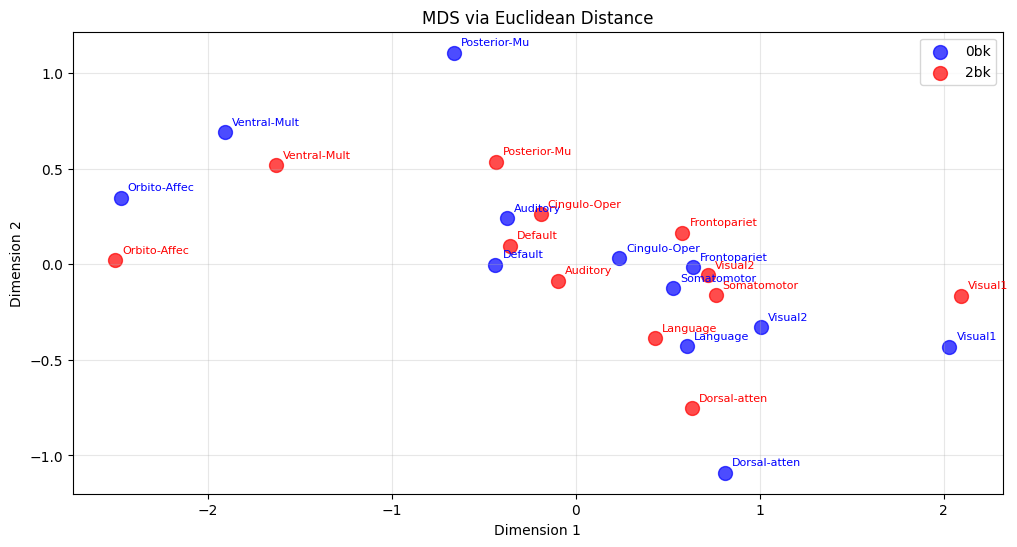

In [ ]:
###########################################################################
# MDS plotting for two conditions across 2 dimensions
# Since MDS needs same-length vectors, I standardized the correlation matrices
# on a fisher z scale and used the quantiles to calculate euclidean distance

# Below it there's a plotting function for single networks with raw correlations
############################################################################

# Build fixed-length quantile feature vectors for each network and condition
quantile_levels = np.linspace(0, 100, 200)  # no. of quantiles
z_quant = {'0bk': [], '2bk': []}
for cond, key in zip(['0bk','2bk'], ['0bk_faces','2bk_faces']):
    for net in unq_networks:
        corr, _ = get_net_corr_all_subjects(net, net, my_exp, key, my_run, test_subjects)
        triu = np.triu_indices(corr.shape[0], k=1)
        flat = corr[triu]
        z = np.arctanh(flat) # Fisher z
        zq = np.percentile(z, quantile_levels)
        z_quant[cond].append(zq)

D0 = pairwise_euclid(z_quant['0bk'])
D2 = pairwise_euclid(z_quant['2bk'])
print(f"Distance matrices shapes: {D0.shape}, {D2.shape}")

# MDS embedding with precomputed dissimilarity
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords0 = mds.fit_transform(D0)
coords2 = mds.fit_transform(D2)

# Plot both conditions in the same space
plt.figure(figsize=(12, 6))
plt.scatter(coords0[:, 0], coords0[:, 1], c='blue', label='0bk', s=100, alpha=0.7)
plt.scatter(coords2[:, 0], coords2[:, 1], c='red', label='2bk', s=100, alpha=0.7)

# Annotate each network
for i, net in enumerate(unq_networks):
    plt.annotate(net, (coords0[i, 0], coords0[i, 1]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='blue')
    plt.annotate(net, (coords2[i, 0], coords2[i, 1]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='red')

plt.legend()
plt.title('MDS via Euclidean Distance')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
########################################################################################
# Single-network MDS plotting

# This doesn't have the problem of vectors of different lengths since it's the same
# network compared across 0bk and 2bk, so using the raw corrs to calculate distance is
# good enough, no need for z scores and all that jazz
########################################################################################

def plot_single_network_mds(network):
    """Run MDS for one network comparing raw correlation matrices between 0bk and 2bk conditions.

    Args:
        network : str
            Name of the network to analyze (must match entries in region_info['network']).

    Return:
        Shows a Matplotlib figure and prints the Euclidean distance between
        the two condition vectors.
    """
    # Get correlation matrices for both conditions
    cond_keys = [('0bk', '0bk_faces'), ('2bk', '2bk_faces')]
    corr_matrices = []

    for cond, key in cond_keys:
        corr, _ = get_net_corr_all_subjects(network, network, my_exp, key, my_run, test_subjects)
        corr_matrices.append(corr)

    # Extract upper triangular parts (excluding diagonal) for comparison
    corr_vectors = []
    for corr in corr_matrices:
        flat = corr[np.triu_indices(corr.shape[0], k=1)]
        #flat = corr.flatten()
        corr_vectors.append(flat)


    # Compute pairwise Euclidean distance between the correlation vectors
    D = pairwise_euclid(corr_vectors)


    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(D)


    plt.figure(figsize=(8, 6))
    for i, (cond, _) in enumerate(cond_keys):
        plt.scatter(coords[i, 0], coords[i, 1], label=cond, s=150, alpha=0.8)
        plt.annotate(cond, (coords[i, 0], coords[i, 1]), xytext=(5, 5), textcoords='offset points')

    plt.title(f'MDS Comparison (Raw Correlations): 0bk vs 2bk for {network}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Euclidean distance between conditions: {D[0,1]:.3f}")

In [ ]:
##############################################################################
# The classifier we all know and love
#############################################################################

def svm_classify_all_networks(test_size=0.3, random_state=42):
    """
    Train a single SVM using features from all networks to classify 0bk vs 2bk.

    This creates one unified model that considers patterns across all brain networks
    simultaneously, using subject-level data.

    Args:
        test_size: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with classification results
    """
    print("=== Unified SVM Classification Using All Networks (Subject-Level) ===")
    print("Training a single SVM on features from all brain networks combined...")
    print("Using subject-level data to create proper sample size...")

    # Get subject-level features from all networks for all WM conditions
    X, y, sample_info = get_all_networks_features_subject_level('WM', my_run, test_subjects)

    if len(X) == 0:
        raise ValueError("No valid feature vectors found")

    print(f"\nDataset created:")
    print(f"  Total samples: {len(X)}")
    print(f"  Features per sample: {X.shape[1]} (combined from all networks)")
    print(f"  Class distribution: {np.bincount(y)} (0=0bk, 1=2bk)")
    print(f"  Sample composition: {len([s for s in sample_info if s[1].startswith('0bk')])} 0bk samples, {len([s for s in sample_info if s[1].startswith('2bk')])} 2bk samples")

    # Split into train/test sets
    # Splitting them into groups so the data from the same subject doesn't
    # end up in both train and test data
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    group_train = [groups[i] for i in train_idx]

    print("\nStandardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train unified SVM classifier
    print("Training unified SVM classifier...")
    svm = SVC(kernel='linear', random_state=random_state)
    svm.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = svm.score(X_test_scaled, y_test)

    # Cross-validation !!(not using full dataset)!!
    # Not entirely sure what's going on over here
    print("Performing cross-validation...")
    gkf = GroupKFold(n_splits=5)
    cv_scores = cross_val_score(svm, X_train_scaled, y_train,
                                groups=group_train, cv=gkf)

    # Results
    print(f"\n=== UNIFIED SVM RESULTS ===")
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Cross-validation Accuracy: {cv_scores.mean():.3f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['0bk (all networks)', '2bk (all networks)']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0bk (all networks)', '2bk (all networks)'],
                yticklabels=['0bk (all networks)', '2bk (all networks)'])
    plt.title('Unified SVM: All Networks Combined\n0bk vs 2bk Classification (Subject-Level Data)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature importance analysis

    # I'm not using this anymore, didn't manage to plot it and I bailed
    # I return it in the dict

    # This is a feature i had when the feature vector wasn't this large and was
    # still testing with single networks.
    # Right now it just returns correlation numbers. They would have to be tied
    # back to what parcels they measure and the network they belong to in order
    # to determine which network or parcel was more influential
    feature_importance = np.abs(svm.coef_[0]) if hasattr(svm, 'coef_') else None

    print(f"\nModel Details:")
    print(f"  Total features used: {X.shape[1]}")
    print(f"  Networks combined: {len(unq_networks)}")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")
    # This only works for the 'WM' experiment
    print(f"  Samples per condition: ~{len(X) // 8} (across all conditions)")

    # Show sample composition
    condition_counts = {}
    for _, condition in sample_info:
        condition_counts[condition] = condition_counts.get(condition, 0) + 1

    print(f"\nSample composition:")
    for condition, count in sorted(condition_counts.items()):
        print(f"  {condition}: {count} samples")

    return {
        'accuracy': accuracy,
        'cv_scores': cv_scores,
        'confusion_matrix': cm,
        'classifier': svm,
        'scaler': scaler,
        'n_samples': len(X),
        'n_features': X.shape[1],
        'feature_importance': feature_importance,
        'sample_info': sample_info,
        'condition_counts': condition_counts
    }

def svm_classify_single_network(network, test_size=0.3, random_state=42, plot_results=True):
    """
    Train an SVM classifier for a single brain network to classify 0bk vs 2bk conditions.

    Args:
        network (str): Name of the brain network to analyze
        test_size (float): Fraction of data to use for testing
        random_state (int): Random seed for reproducibility
        plot_results (bool): Whether to show confusion matrix plot

    Returns:
        dict: Dictionary with classification results including accuracy, confusion matrix, etc.
    """
    print(f"\n{'='*60}")
    print(f"=== SVM Classification for {network} Network ===")
    print(f"{'='*60}")

    # Get subject-level features from the specified network
    X, y, sample_info = get_single_network_features_subject_level(
        network, 'WM', my_run, test_subjects
    )

    if len(X) == 0:
        print(f"ERROR: No valid feature vectors found for {network}")
        return None

    print(f"\nDataset for {network}:")
    print(f"  Total samples: {len(X)}")
    print(f"  Features per sample: {X.shape[1]}")
    print(f"  Class distribution: {np.bincount(y)} (0=0bk, 1=2bk)")

    groups = [subj for subj, _ in sample_info]

    # Split by subject
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    group_train = [groups[i] for i in train_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Train
    svm = SVC(kernel='rbf', random_state=random_state)
    svm.fit(X_train_scaled, y_train)



    # Make predictions
    y_pred = svm.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = svm.score(X_test_scaled, y_test)

     # Cross‐val **also** by subject
    from sklearn.model_selection import GroupKFold, cross_val_score
    gkf = GroupKFold(n_splits=5)
    cv_scores = cross_val_score(svm, X_train_scaled, y_train,
                                groups=group_train, cv=gkf)

    # Results
    print(f"\n=== {network.upper()} NETWORK RESULTS ===")
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[f'0bk ({network})', f'2bk ({network})']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    if plot_results:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f'0bk', f'2bk'],
                    yticklabels=[f'0bk', f'2bk'])
        plt.title(f'{network} Network: 0bk vs 2bk Classification\nAccuracy: {accuracy:.3f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Sample composition
    condition_counts = {}
    for _, condition in sample_info:
        condition_counts[condition] = condition_counts.get(condition, 0) + 1

    return {
        'network': network,
        'accuracy': accuracy,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'confusion_matrix': cm,
        'classifier': svm,
        'scaler': scaler,
        'n_samples': len(X),
        'n_features': X.shape[1],
        'sample_info': sample_info,
        'condition_counts': condition_counts,
        'train_test_split': (len(X_train), len(X_test))
    }

def analyze_all_networks_individually(networks=None, test_size=0.3, random_state=42,
                                    plot_individual=True, plot_summary=True):
    """
    Run SVM classification for each brain network individually and compare results.

    Args:
        networks (list): List of network names to analyze (if None, uses all unique networks)
        test_size (float): Fraction of data to use for testing
        random_state (int): Random seed for reproducibility
        plot_individual (bool): Whether to plot confusion matrix for each network
        plot_summary (bool): Whether to plot summary comparison across networks

    Returns:
        dict: Dictionary mapping network names to their classification results
    """
    if networks is None:
        networks = list(unq_networks)

    print(f"\n{'='*80}")
    print(f"=== INDIVIDUAL NETWORK ANALYSIS ===")
    print(f"Analyzing {len(networks)} networks: {networks}")
    print(f"{'='*80}")

    results = {}

    for network in networks:
        try:
            result = svm_classify_single_network(
                network, test_size=test_size, random_state=random_state,
                plot_results=plot_individual
            )
            if result is not None:
                results[network] = result

        except Exception as e:
            print(f"ERROR analyzing {network}: {e}")
            continue

    if not results:
        print("ERROR: No networks were successfully analyzed!")
        return {}

    # Summary analysis
    print(f"\n{'='*80}")
    print(f"=== SUMMARY ACROSS {len(results)} NETWORKS ===")
    print(f"{'='*80}")

    # Sort networks by accuracy
    sorted_networks = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    print(f"\nNetwork Performance Ranking:")
    print(f"{'Network':<15} {'Accuracy':<10} {'CV Mean±Std':<15} {'N Samples':<10} {'N Features':<10}")
    print(f"{'-'*70}")

    for network, result in sorted_networks:
        cv_mean = result['cv_mean']
        cv_std = result['cv_std']
        print(f"{network:<15} {result['accuracy']:<10.3f} {cv_mean:.3f}±{cv_std:<7.3f} {result['n_samples']:<10} {result['n_features']:<10}")

    if plot_summary:
        # Summary plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Accuracy comparison
        networks_list = list(results.keys())
        accuracies = [results[net]['accuracy'] for net in networks_list]
        cv_means = [results[net]['cv_mean'] for net in networks_list]
        cv_stds = [results[net]['cv_std'] for net in networks_list]

        x_pos = np.arange(len(networks_list))
        axes[0, 0].bar(x_pos, accuracies, alpha=0.7, color='skyblue', label='Test Accuracy')
        axes[0, 0].errorbar(x_pos, cv_means, yerr=cv_stds, fmt='ro', label='CV Mean±Std')
        axes[0, 0].set_xlabel('Network')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Classification Accuracy by Network')
        axes[0, 0].set_xticks(x_pos)
        axes[0, 0].set_xticklabels(networks_list, rotation=45, ha='right')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 3. Feature dimensions
        n_features = [results[net]['n_features'] for net in networks_list]
        axes[0, 1].bar(x_pos, n_features, alpha=0.7, color='lightcoral')
        axes[0, 1].set_xlabel('Network')
        axes[0, 1].set_ylabel('Number of Features')
        axes[0, 1].set_title('Feature Dimension by Network')
        axes[0, 1].set_xticks(x_pos)
        axes[0, 1].set_xticklabels(networks_list, rotation=45, ha='right')
        axes[0, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Performance statistics
    accuracies_array = np.array(accuracies)
    print(f"\nOverall Performance Statistics:")
    print(f"  Mean accuracy: {np.mean(accuracies_array):.3f} ± {np.std(accuracies_array):.3f}")
    print(f"  Best network: {sorted_networks[0][0]} ({sorted_networks[0][1]['accuracy']:.3f})")
    print(f"  Worst network: {sorted_networks[-1][0]} ({sorted_networks[-1][1]['accuracy']:.3f})")
    print(f"  Networks above 60% accuracy: {sum(1 for acc in accuracies if acc > 0.6)}/{len(accuracies)}")


###############################################################################
# Permutation testing function

# Note: This function is only for the ALL Network classifier
###############################################################################

def permutation_test_svm(n_permutations=1000, test_size=0.3, random_state=42):
    """
    Perform permutation testing on the unified SVM classifier.

    This tests the null hypothesis that the classifier is just finding random patterns
    by shuffling the labels many times and comparing to the real accuracy.

    Args:
        n_permutations: Number of permutations to perform
        test_size: Fraction of data to use for testing (same as original)
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with permutation test results
    """
    print(f"=== Permutation Testing ({n_permutations:,} permutations) ===")
    print("Testing null hypothesis: classifier finds only random patterns")

    # Get the same data as the original classifier
    print("Loading data...")
    X, y, sample_info = get_all_networks_features_subject_level('WM', my_run, test_subjects)

    if len(X) == 0:
        raise ValueError("No valid feature vectors found")

    print(f"Data loaded: {len(X)} samples, {X.shape[1]} features")

    # Train/test split based on groups to avoid leaking subject data into both
    # train and split
    groups = [subj for subj, _ in sample_info]
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Train/test split: {len(X_train)} / {len(X_test)} samples")

    # Get real accuracy
    print("Computing real accuracy...")
    real_svm = SVC(kernel='rbf', random_state=random_state)
    real_svm.fit(X_train_scaled, y_train_real)
    real_accuracy = real_svm.score(X_test_scaled, y_test_real)
    print(f"Real accuracy: {real_accuracy:.3f}")

    # Perform permutation testing
    print(f"\nRunning {n_permutations:,} permutations...")
    permuted_accuracies = []

    for perm in range(n_permutations):
        # Shuffle labels randomly
        y_shuffled = np.random.permutation(y)

        # Split shuffled labels using same indices
        y_train_perm = y_shuffled[train_idx]
        y_test_perm  = y_shuffled[test_idx]

        # !!Non-linear kernel!!
        perm_svm = SVC(kernel='rbf', random_state=random_state)
        perm_svm.fit(X_train_scaled, y_train_perm)
        permuted_accuracies.append(perm_svm.score(X_test_scaled, y_test_perm))

        # Progress update
        if (perm + 1) % 100 == 0:
            print(f"  Completed {perm + 1:,} / {n_permutations:,} permutations...")

    permuted_accuracies = np.array(permuted_accuracies)

    # Calculate p-value
    p_value = (np.sum(permuted_accuracies >= real_accuracy) + 1) / (n_permutations + 1)

    # Summary statistics
    mean_perm_acc = np.mean(permuted_accuracies)
    std_perm_acc = np.std(permuted_accuracies)
    max_perm_acc = np.max(permuted_accuracies)

    print(f"\n=== PERMUTATION TEST RESULTS ===")
    print(f"Real accuracy: {real_accuracy:.3f}")
    print(f"Mean permuted accuracy: {mean_perm_acc:.3f} ± {std_perm_acc:.3f}")
    print(f"Max permuted accuracy: {max_perm_acc:.3f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

    # Effect size (how many standard deviations above chance)
    effect_size = (real_accuracy - mean_perm_acc) / std_perm_acc
    print(f"Effect size (Z-score): {effect_size:.2f}")

    return {
        'real_accuracy': real_accuracy,
        'permuted_accuracies': permuted_accuracies,
        'p_value': p_value,
        'mean_permuted': mean_perm_acc,
        'std_permuted': std_perm_acc,
        'max_permuted': max_perm_acc,
        'effect_size': effect_size,
        'n_permutations': n_permutations,
        'significant': p_value < 0.05
    }



=== Unified SVM Classification Using All Networks (Subject-Level) ===
Training a single SVM on features from all brain networks combined...
Using subject-level data to create proper sample size...
=== Getting Subject-Level Features from All Networks ===
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
0bk conditions: ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
2bk conditions: ['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']
Networks: [np.str_('Auditory'), np.str_('Cingulo-Oper'), np.str_('Default'), np.str_('Dorsal-atten'), np.str_('Frontopariet'), np.str_('Language'), np.str_('Orbito-Affec'), np.str_('Posterior-Mu'), np.str_('Somatomotor'), np.str_('Ventral-Mult'), np.str_('Visual1'), np.str_('Visual2')]

Processing 0bk_body...
  Added 100 samples for 0bk_body

Processing 0bk_faces...
  Added 100 samples for 0bk_faces

Processing 0bk_places...
  Added 100 samples for 0bk_places

Processing 0bk_tools...
  Added 100 samples for 0bk_tools

Processing 2bk_body...


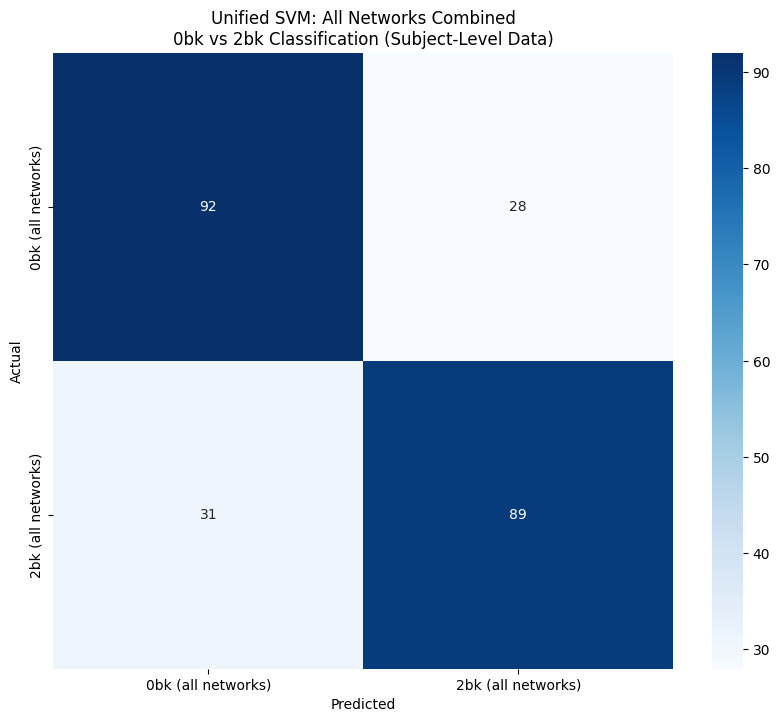


Model Details:
  Total features used: 8531
  Networks combined: 12
  Training samples: 560
  Test samples: 240
  Samples per condition: ~100 (across all conditions)

Sample composition:
  0bk_body: 100 samples
  0bk_faces: 100 samples
  0bk_places: 100 samples
  0bk_tools: 100 samples
  2bk_body: 100 samples
  2bk_faces: 100 samples
  2bk_places: 100 samples
  2bk_tools: 100 samples


In [ ]:
# Putting these down here again since they are needed for running the classifier
# and i think it'd be more handy having these here and to not having to scroll up

regions = np.load(f"{HCP_DIR}/regions.npy")
region_info = dict(name=regions[:, 0].tolist(),
                   network=regions[:, 1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

unq_networks = np.unique(region_info['network'])
test_subjects = None

###############################################################################
# Run classifier
###############################################################################

results = svm_classify_all_networks()

In [ ]:
# Example usage: Analyze a single network
# frontoparietal_results = svm_classify_single_network('Frontoparietal')

# Example usage: Analyze all networks individually
all_network_results = analyze_all_networks_individually()

# Example usage: Analyze specific networks only
# selected_networks = ['Frontoparietal', 'Default', 'DorsalAttn', 'Visual']
# selected_results = analyze_all_networks_individually(networks=selected_networks)

In [ ]:
##############################################################################
# Run permutation testing
##############################################################################

# In VS code, on my setup, it takes ~40 minutes for 1000 permutations
# Colab seems to be a lot slower so be patient with it (1 hour and 3 minutes for 1000 permutations)
test_results = permutation_test_svm(n_permutations=1000, test_size=0.3, random_state=42)

=== Permutation Testing (1,000 permutations) ===
Testing null hypothesis: classifier finds only random patterns
Loading data...
=== Getting Subject-Level Features from All Networks ===
Loaded 100 subjects from /content/hcp_task/subjects_list.txt
0bk conditions: ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
2bk conditions: ['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']
Networks: [np.str_('Auditory'), np.str_('Cingulo-Oper'), np.str_('Default'), np.str_('Dorsal-atten'), np.str_('Frontopariet'), np.str_('Language'), np.str_('Orbito-Affec'), np.str_('Posterior-Mu'), np.str_('Somatomotor'), np.str_('Ventral-Mult'), np.str_('Visual1'), np.str_('Visual2')]

Processing 0bk_body...
  Added 100 samples for 0bk_body

Processing 0bk_faces...
  Added 100 samples for 0bk_faces

Processing 0bk_places...
  Added 100 samples for 0bk_places

Processing 0bk_tools...
  Added 100 samples for 0bk_tools

Processing 2bk_body...
  Added 100 samples for 2bk_body

Processing 2bk_faces...
  Added 100